In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_cols = list(train_df.columns)
test_cols = list(test_df.columns)
train_cols.remove('fiberID')
test_cols.remove('fiberID')

## DATA Setting

In [6]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [7]:
def add_minus_feature(data,test = False):
    '''
    mag별 ugriz밴드간의 근접변수에 대해서만 컬럼생성 color-color map 참고
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    (추가옵션)각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [8]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

train_df.shape, test_df.shape

((199991, 39), (10009, 37))

### PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA(1)

In [10]:
ori_name = ["psfMag","fiberMag","petroMag","modelMag"]
add_name = ["u","g","r","i","z"]

In [11]:
for add in add_name:
    selected = list(map(lambda x : x+"_"+add,ori_name))
    train_df['PCA_'+add] = pca.fit_transform(train_df[selected])
    test_df['PCA_'+add] = pca.fit_transform(test_df[selected])

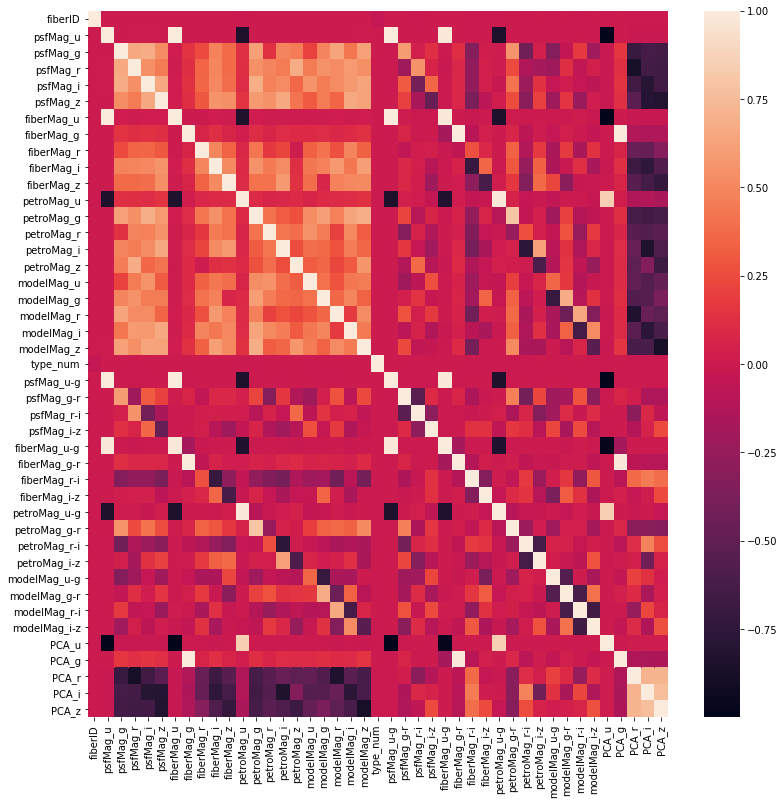

In [12]:
plt.figure(figsize=(13,13))
sns.heatmap(train_df.corr())

In [13]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_g-r', 'psfMag_r-i',
       'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i',
       'fiberMag_i-z', 'petroMag_u-g', 'petroMag_g-r', 'petroMag_r-i',
       'petroMag_i-z', 'modelMag_u-g', 'modelMag_g-r', 'modelMag_r-i',
       'modelMag_i-z', 'PCA_u', 'PCA_g', 'PCA_r', 'PCA_i', 'PCA_z'],
      dtype='object')

In [14]:
train_X= train_df.drop(['type','type_num','fiberID'],axis = 1)
test_X = test_df.drop(['fiberID'],axis = 1)
train_y = train_df['type_num']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

### modeling

In [16]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 127, min_child_samples = 50,
                            max_depth = 8, learning_rate = 0.01,
                            lambda_l2 = 7, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [ ]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_train,y_train),(X_test, y_test)],eval_names= ['train','valid'], 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.922929	valid's multi_logloss: 0.940042
[200]	train's multi_logloss: 0.588194	valid's multi_logloss: 0.613218
[300]	train's multi_logloss: 0.458916	valid's multi_logloss: 0.489632
[400]	train's multi_logloss: 0.400749	valid's multi_logloss: 0.436325
[500]	train's multi_logloss: 0.370301	valid's multi_logloss: 0.41037
[600]	train's multi_logloss: 0.352009	valid's multi_logloss: 0.396378
[700]	train's multi_logloss: 0.339261	valid's multi_logloss: 0.387961


In [ ]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

In [ ]:
train_y_pred

In [ ]:
test_y_pred = lgbm_c.predict_proba(test_X)

In [ ]:
test_y_pred

### feature_importance

In [ ]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [ ]:
train_y_pred = lgbm_c.predict(X_test)

In [ ]:
train_y_pred.shape

In [ ]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [ ]:
cm_result

In [ ]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [29]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [ ]:
lgbm_c.fit(train_X, train_y, eval_set = [(train_X, train_y)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.316216
[200]	valid's multi_logloss: 0.271117
[300]	valid's multi_logloss: 0.2408


In [ ]:
f_train_y_pred = lgbm_c.predict_proba(train_X)

In [ ]:
y_pred = lgbm_c.predict_proba(test_X)

In [ ]:
y_pred

In [33]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)